# Loading Libraries

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
# To ignore warnings
import warnings
warnings.simplefilter(action="ignore")
# Import neccessary libraries for ML part
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import ConfusionMatrixDisplay

# Prepare Data

## Import 

In [2]:
# Loading dataset
df = pd.read_csv('CVD_cleaned.csv')
df.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


## Cleaning Data

In [3]:
# Number of rows and columns in the dataset
df.shape

(308854, 19)

In [4]:
# Information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 308854 non-null  object 
 4   Skin_Cancer                   308854 non-null  object 
 5   Other_Cancer                  308854 non-null  object 
 6   Depression                    308854 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age_Category                  308854 non-null  object 
 11  Height_(cm)                   308854 non-null  float64
 12  Weight_(kg)                   308854 non-nul

In [5]:
# Checking for missing values
df.isnull().sum().sum()

0

In [6]:
# Checking for duplicated rows
df.duplicated().sum()

80

In [7]:
# Dropping the duplicates
df.drop_duplicates(inplace=True)

The dataset is mostly clean (no null object or incorrect data types, etc).

## EDA

In [8]:
# Geting a look on summary statistics
df.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,308774.000000,308774.000000,308774.000000,308774.000000,308774.000000,308774.000000,308774.000000
mean,170.615220,83.590399,28.626813,5.097557,29.834290,15.109517,6.297237
std,10.658452,21.344664,6.522810,8.200434,24.877812,14.926912,8.583837
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,293.020000,99.330000,30.000000,120.000000,128.000000,128.000000


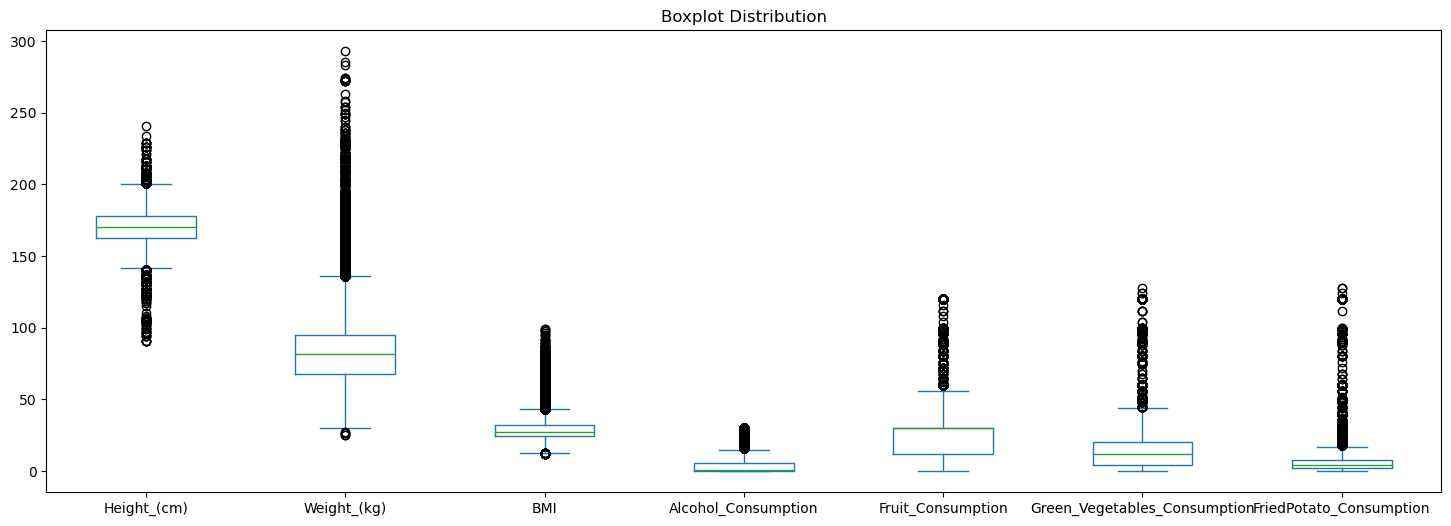

In [9]:
# Visualize distribution of numeric data using boxplot
fig, ax = plt.subplots(figsize = (18, 6))
df.plot(kind = 'box', title = 'Boxplot Distribution', ax=ax);

There's outliers in all my numeric data, but it seems that these numbers could happen in real life, like in weight it could exceeds 250 Kg, so I'm keeping them.

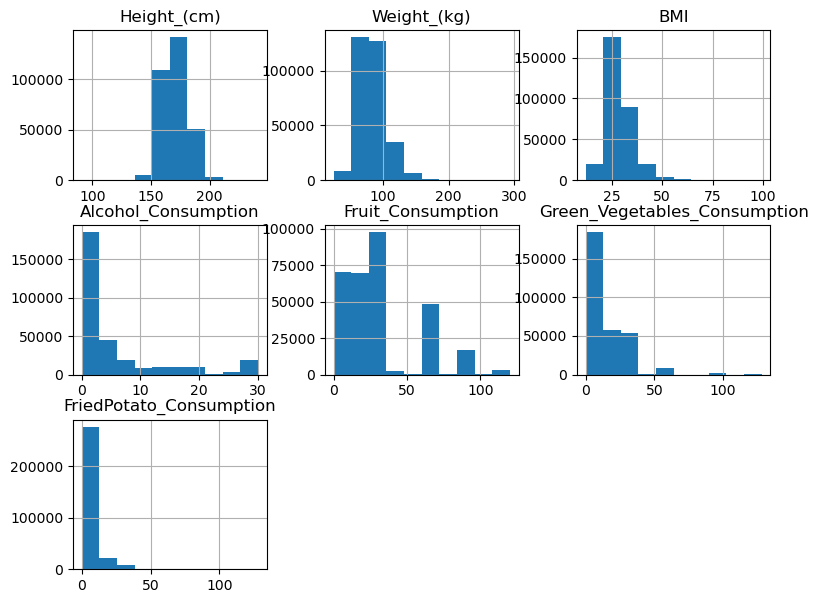

In [10]:
# Getting a look at the distribution using histogram
fig, ax = plt.subplots(figsize=(9, 7))
df.hist(ax=ax);

1- Weight and height seems to have symmetric distribution. Most of weight range between 50 to 100 Kg.

2- BMI positively skewed.

3- The rest of numeric data are all right skewed.

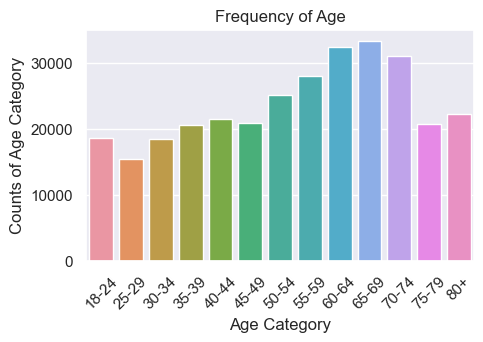

In [11]:
# Visualization of Age Frequency
order = df['Age_Category'].sort_values().unique()
sns.set(rc={"figure.figsize": (5, 3)})
my_plot = sns.countplot(data=df, x='Age_Category', order = order) 
my_plot.set(xlabel='Age Category', ylabel='Counts of Age Category', title='Frequency of Age')
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45);

Older ages from 50 to 75 have higher frequencies than other age categories in the dataset.

Let's take a look on 'Exercise', 'Heart_Disease', 'Depression', 'Diabetes', and 'Smoking_History' columns. We want to see counts of each values as in 'Yes' and 'No' counts.

In [12]:
columns_y_n = ['Exercise', 'Heart_Disease', 'Depression', 'Diabetes', 'Smoking_History']

In [13]:
# Create empty DataFrame
df_2 = pd.DataFrame()
# Loop on counts of 'No' and 'Yes' for the 5 columns in df and assign them to df_2
for col in columns_y_n:
    counts = df[col].value_counts()
    df_2[col] = np.array([counts['No'], counts['Yes']])
# Set index of df_2 to ['No', 'Yes']
df_2.set_index(pd.Index(['No', 'Yes']), inplace=True)
df_2

,Exercise,Heart_Disease,Depression,Diabetes,Smoking_History
No,69469,283803,246875,259062,183516
Yes,239305,24971,61899,40170,125258


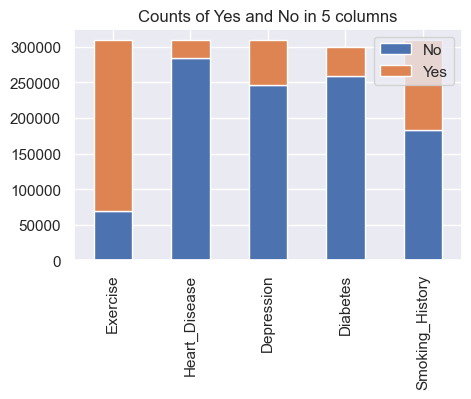

In [14]:
# transpose df_2 
df_T = df_2.T
# Stacked bar visualization of 'Exercise', 'Heart_Disease', 'Depression', 'Diabetes', 'Smoking_History' columns
df_T.plot(kind='bar', stacked=True)
plt.title('Counts of Yes and No in 5 columns');

Observation

1- The mojority do exercise.

2- Heart_Disease and Diabetes most of it have is 'No' and Depression has higher numbers of 'Yes' but still 'No' is the majority.

3- Smoking_History have High numbers of 'Yes' almost the half.

# Analyzing Data

### Qeustion 1:  Is there a relationship between heart disease and smoking history?

**A) Relation between heart disease and smoking history across age categories**

In [15]:
# Check That there're 2 unique values only [yes, No] in smoking history column
df['Smoking_History'].unique()

array(['Yes', 'No'], dtype=object)

In [16]:
# Check That there're 2 unique values only [yes, No] in heart disease column
df['Heart_Disease'].unique()

array(['No', 'Yes'], dtype=object)

We create new columns to represent (Yes and No) values as (1 and 0) for easier calculations and visualization

In [17]:
# Replace values 'yes' and 'no' with '1' and '0' respectively of Heart Disease column
df['Heart_Disease_01'] = df['Heart_Disease'].replace('Yes', 1).replace('No', 0).astype('int')
# Replace values 'yes' and 'no' with '1' and '0' respectively of Smoking History column
df['Smoking_History_01'] = df['Smoking_History'].replace('Yes', 1).replace('No', 0).astype('int')

In [18]:
df.head(3)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,...,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,Heart_Disease_01,Smoking_History_01
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,...,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0,0,1
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,...,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0,1,0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,...,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0,0,0


In [19]:
# Getting a look on heart diease proportions across smoking history and age categories.
age_smoking_heartdis_prop = df.groupby(['Age_Category','Smoking_History'])['Heart_Disease_01'].mean()
age_smoking_heartdis_prop

Age_Category  Smoking_History
18-24         No                 0.004434
              Yes                0.008660
25-29         No                 0.005434
              Yes                0.012189
30-34         No                 0.007645
              Yes                0.016687
35-39         No                 0.008574
              Yes                0.020237
40-44         No                 0.011631
              Yes                0.031425
45-49         No                 0.021377
              Yes                0.048659
50-54         No                 0.029752
              Yes                0.074567
55-59         No                 0.048363
              Yes                0.102724
60-64         No                 0.061935
              Yes                0.130753
65-69         No                 0.083288
              Yes                0.152089
70-74         No                 0.113688
              Yes                0.184401
75-79         No                 0.145748
    

Numbers are great demonstrator but to visualize them is even better, so.... 

In [20]:
#convert age_sage_smoking_heartdis_prop into percentages
age_smoking_heartdis_prop *= 100

In [21]:
# Setting tick labels for x axis
ticklabel = []
for i in age_smoking_heartdis_prop.index:
    ticklabel.append(i[0])

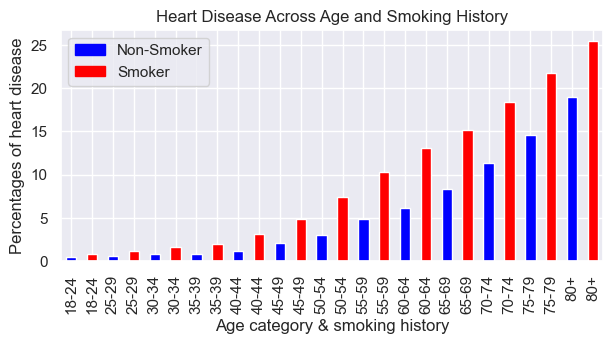

In [22]:
# plotting heart diease percentages across age categories and smoking history 
colors = {'Non-Smoker': 'Blue', 'Smoker': "Red"}
labels = list(colors.keys())
age_smoking_heartdis_prop.plot.bar(color = ['blue', 'red'], figsize=(7, 3))
plt.xlabel('Age category & smoking history')
plt.ylabel('Percentages of heart disease')
plt.title('Heart Disease Across Age and Smoking History')
plt.xticks(np.arange(len(ticklabel)), ticklabel)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels);


***<span style="color:blue"> Insights </span>*** :
We can see that there's a relation between smoking and heart disease across different age categories as there are increasing numbers of heart disease for people who smoke. 

**B) Checking for a relation between smoking history and heart disease only**

In [23]:
# Proportions of heart disease for non-smokers and smokers
df.groupby('Smoking_History')['Heart_Disease_01'].mean()

Smoking_History
No     0.056600
Yes    0.116432
Name: Heart_Disease_01, dtype: float64

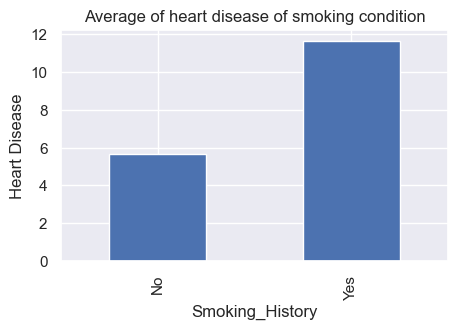

In [24]:
# Plotting the Percentage of heart disease for non-smokers and smokers
(df.groupby('Smoking_History')['Heart_Disease_01'].mean()*100).plot.bar()
plt.ylabel('Heart Disease')
plt.title('Average of heart disease of smoking condition');

About 12% of smokers have heart disease and about 6% of non-smokers have heart disease.

In [25]:
# Proportions of smokers for heart diease condition
df.groupby('Heart_Disease')['Smoking_History_01'].mean()

Heart_Disease
No     0.389968
Yes    0.584037
Name: Smoking_History_01, dtype: float64

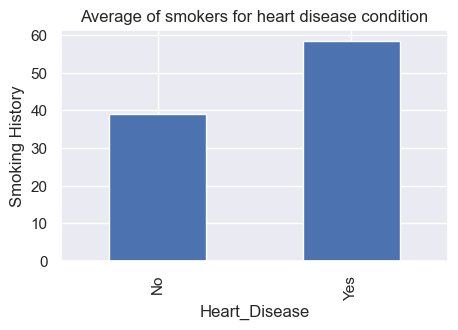

In [26]:
#Plotting the Percentage of smokers for heart diease condition
(df.groupby('Heart_Disease')['Smoking_History_01'].mean()*100).plot.bar()
plt.ylabel('Smoking History')
plt.title('Average of smokers for heart disease condition');

***<span style="color:blue"> Insights </span>*** :
There's about 60% of people with heart disease who smoke and about 40% of people who don't have heart disease do smoke.

By considering both ways percentages for heart disease and smoking history we can say that there is a relationship between them.

### Question 2: Is the probability of having a heart disease is the same or different as for those who smoke and for those who don't?

**Hypothesis Testing**

Null Hypothesis => The Propability of people who smoke and have heart disease is the same as the people who don't smoke and have heart disease

<span style="color:green">mean(smoking) - mean(non-smoking) <= 0</span>

$H_0$ :  <span style="color:green">Ms - Mns <= 0</span>

Alternative Hypothesis => The Propability of people who smoke and have heart disease is greater than the people who don't smoke

<span style="color:green">mean(smoking) - mean(non-smoking) > 0</span>

$H_1$ : <span style="color:green">Ms - Mns > 0</span>

alpha = .05

In [27]:
# Subset the data into non-smokers only and using column Heart_Disease
df_nonsmokers = df[df['Smoking_History_01'] == 0]['Heart_Disease_01']

In [28]:
# Subset the data into smokers only and using column Heart_Disease
df_smokers = df[df['Smoking_History_01'] == 1]['Heart_Disease_01']

In [29]:
# Difference of heart disease proportions between smokers and non-smokers in the original dataset
mean_diff = df_smokers.mean() - df_nonsmokers.mean()
mean_diff

0.05983171551720601

In [30]:
means = []
# Bootstrap from the df_smokers and df_nonsmokers
for _ in range(10000):
    bootsample_smokers = df_smokers.sample(len(df_smokers), replace=True)
    bootsample_nonsmokers = df_nonsmokers.sample(len(df_nonsmokers), replace=True)
    # Difference between two samples' mean
    diff = bootsample_smokers.mean() - bootsample_nonsmokers.mean()
    means.append(diff)

In [31]:
#Get the standard deviation
np.std(means)

0.0010598432391114463

In [32]:
# Simulate dataset from the null hypothesis
null_vals = np.random.normal(0, np.std(means),10000)

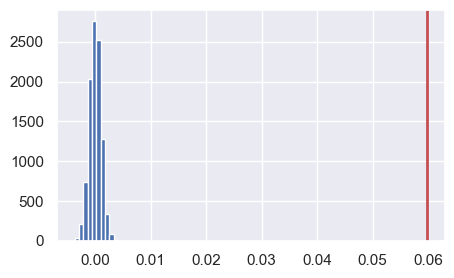

In [33]:
# Histogram of the simulating dataset
plt.hist(null_vals);
plt.axvline(mean_diff,color='r', linewidth=2)

In [34]:
# Compute p-value: p
p = np.sum(null_vals>= mean_diff) / len(null_vals)

# Print the result
print('p-value =', p)

p-value = 0.0


 we would reject the null in favor of the alternative hypothesis stating that the Propability of people who smoke and have heart disease is greater than the people who don't smoke

The test is extremely significant and the probability of making a type 1 error is virtually zero.

### Question 3: Is there a relationship between  General Health and Smoking?

In [35]:
# Proportion of smoking history across general health
general_health_smoking = df.groupby('General_Health')['Smoking_History_01'].mean()
general_health_smoking

General_Health
Excellent    0.297002
Fair         0.535746
Good         0.441875
Poor         0.621834
Very Good    0.365035
Name: Smoking_History_01, dtype: float64

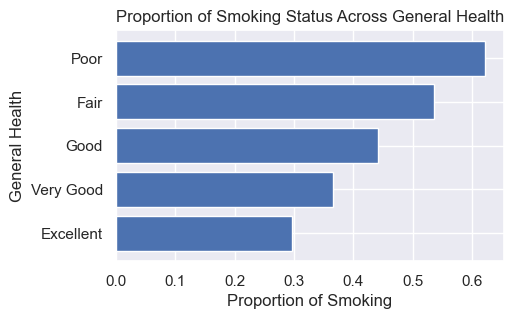

In [36]:
# Horizontal bar chart for the proportion of smoking history across general health
locations = [1, 4, 3, 5, 2]
heights = general_health_smoking
labels = general_health_smoking.index
plt.barh(locations, heights, tick_label = labels)
plt.xlabel('Proportion of Smoking')
plt.ylabel('General Health')
plt.title('Proportion of Smoking Status Across General Health');

There's negative relationship between general health and smoking.

<font size="+3"><strong><span style ="color:blue"> Conclusion </span></strong></font>

- There's a relation between smoking and heart diseas.

- After exercising the hypothesis test we concluded that we favor the alternative hypothesis saying that the probability of having heart disease for smokers is higher than than of those who are non-smokers

- There's also a relation between general health and smoking as higher rates of smokers  [53:62]% associated with poor and fair general health condition.

## Classification 

### Classify and Predict Heart Disease Using Decision Tree Classifier

In [37]:
df.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,...,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,Heart_Disease_01,Smoking_History_01
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,...,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0,0,1
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,...,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0,1,0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,...,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0,0,0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,...,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0,1,0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,...,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0,0,1


In [38]:
df.columns

Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption',
       'Heart_Disease_01', 'Smoking_History_01'],
      dtype='object')

In [39]:
df2 = df.copy()

#### Preprocess Data

In [40]:
df2.drop(columns=['Heart_Disease_01', 'Smoking_History_01'], inplace=True)

In [41]:
df2.columns

Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption'],
      dtype='object')

First we want to check that there're no multicollinearity columns

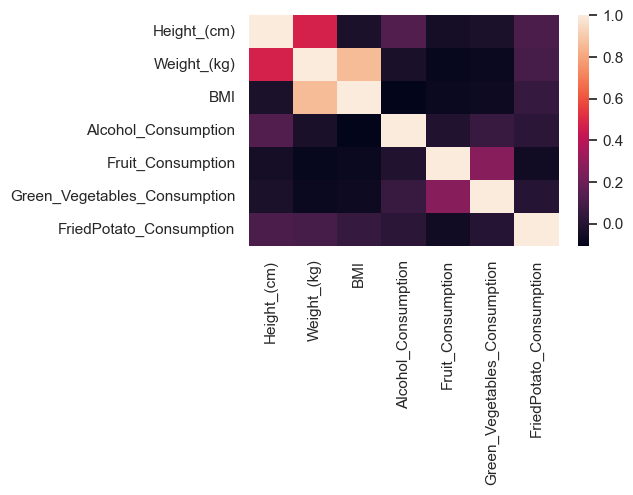

In [42]:
# Create correlation matrix
correlation = df2.select_dtypes('number').corr()
# Plot heatmap of `correlation`
sns.heatmap(correlation);

In [43]:
# Drop multicollinearity column
df2.drop(columns='Weight_(kg)', inplace=True)

There are no high-dimension columns.

Next step is to transform binary columns into numbers

In [44]:
# Create list of binary columns
binary_columns = ['Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer',
                  'Depression', 'Diabetes', 'Arthritis', 'Smoking_History']

In [45]:
# Check if there are other values other than Yes and No
for i in binary_columns:
    if df2[i].nunique() > 2:
        print(f"Column {i} has unique values of \n{df2[i].unique()}", end="\n")

Column Diabetes has unique values of 
['No' 'Yes' 'No, pre-diabetes or borderline diabetes'
 'Yes, but female told only during pregnancy']


In [46]:
df2['Diabetes'].value_counts()

Diabetes
No                                            259062
Yes                                            40170
No, pre-diabetes or borderline diabetes         6896
Yes, but female told only during pregnancy      2646
Name: count, dtype: int64

In [47]:
binary_columns.remove('Diabetes')
binary_columns

['Exercise',
 'Heart_Disease',
 'Skin_Cancer',
 'Other_Cancer',
 'Depression',
 'Arthritis',
 'Smoking_History']

In [48]:
# Replace 'Yes' and 'No' into 1 and 0
for i in binary_columns:
    df2[i].replace({'Yes': 1, 'No': 0}, inplace=True)

In [49]:
# Replace 'Male' and 'Female' in Sex column into 1 and 0
df2['Sex'].replace({'Male': 1, 'Female': 0}, inplace=True)

In [50]:
df2.head(3)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,0,0,0,0,0,No,1,0,70-74,150.0,14.54,1,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,0,1,0,0,0,Yes,0,0,70-74,165.0,28.29,0,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,1,0,0,0,0,Yes,0,0,60-64,163.0,33.47,0,4.0,12.0,3.0,16.0


In [51]:
df2.columns

Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption'],
      dtype='object')

In [52]:
df['Heart_Disease'].value_counts()

Heart_Disease
No     283803
Yes     24971
Name: count, dtype: int64

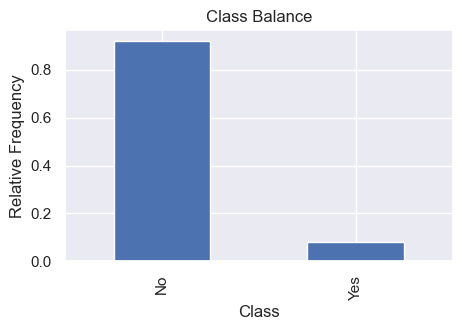

In [53]:
# Majority and minority class
df['Heart_Disease'].value_counts(normalize=True).plot(
     kind='bar', xlabel='Class', ylabel='Relative Frequency', title='Class Balance');

##### Split

In [54]:
# Split into X and y (target)
target = "Heart_Disease"
X = df2.drop(columns=target)
y = df2[target]

In [55]:
# Split into train and test datasets
X_train, X_test, y_train, y_test =  train_test_split(
                                    X, y, test_size=.2, random_state=40)

In [56]:
# Split into train and validation datasets
X_train, X_valid, y_train, y_valid =  train_test_split(
                                    X_train, y_train, test_size=.2, random_state=40)

##### Resample 

In [57]:
X_train.shape

(197615, 17)

In [58]:
# Value counts of heart disease 
y_train.value_counts(normalize=True)

Heart_Disease
0    0.919029
1    0.080971
Name: proportion, dtype: float64

We want to resample the data because there's big difference between minor and major class that would affect the model performance. So first we resample using under- and over-sampling, then we build our decision tree classifier models and fit them using these samples, then we choose which one has the best performance.

In [59]:
# Undersampling
under_sampler = RandomUnderSampler(random_state=40)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)

(32002, 17)


In [60]:
y_train_under.value_counts(normalize=True)

Heart_Disease
0    0.5
1    0.5
Name: proportion, dtype: float64

In [61]:
# OverSampling
over_sampler = RandomOverSampler(random_state=40)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)

(363228, 17)


In [62]:
y_train_over.value_counts(normalize=True)

Heart_Disease
0    0.5
1    0.5
Name: proportion, dtype: float64

#### Build Model

In [63]:
# Baseline
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.919


##### Iterate

We will create three identical models: model_reg, model_under and model_over and fit them on the corresponding training set.
We use Ordinal Encoding to transfrom categorical data into numerical data.

In [64]:
# Train model_reg using the unaltered training data. 
# Fit on (X_train, y_train)
model_reg = make_pipeline(
    OrdinalEncoder(), DecisionTreeClassifier(random_state=40)
)
model_reg.fit(X_train, y_train)

#For model_under, we use the undersampled data. 
# Fit on (X_train_under, y_train_under)
model_under = make_pipeline(
    OrdinalEncoder(), DecisionTreeClassifier(random_state=40)
)
model_under.fit(X_train_under, y_train_under)

#For model_over, we use the oversampled data.
# Fit on (X_train_over, y_train_over)
model_over = make_pipeline(
    OrdinalEncoder(), DecisionTreeClassifier(random_state=40)
)
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['General_Health', 'Checkup', 'Diabetes',
                                      'Age_Category'],
                                mapping=[{'col': 'General_Health',
                                          'data_type': dtype('O'),
                                          'mapping': Very Good    1
Fair         2
Excellent    3
Good         4
Poor         5
NaN         -2
dtype: int64},
                                         {'col': 'Checkup',
                                          'data_type': dtype('O'),
                                          'mapping': Within the past year       1
Within the past 2 years    2
5 or more years ago        3
Within the past 5 years...
                                          'data_type': dtype('O'),
                                          'mapping': No                                            1
Yes                                           2
No, pre-diabetes or borderline diabetes       3
Yes, but female told only during pregnancy    4
NaN                                          -2
dtype: int64},
                                         {'col': 'Age_Category',
                                          'data_type': dtype('O'),
                                          'mapping': 40-44     1
65-69     2
60-64     3
45-49     4
50-54     5
80+       6
75-79     7
18-24     8
55-59     9
70-74    10
30-34    11
25-29    12
35-39    13
NaN      -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=40))])

Now want to choose the best model based on accuracy score and using confusion matrix

In [65]:
# Evaluate 
for m in [model_reg, model_under, model_over]:
    acc_train = m.score(X_train, y_train)
    acc_valid = m.score(X_valid, y_valid)

    print("Training Accuracy:", round(acc_train, 4))
    print("Validation Accuracy:", round(acc_valid, 4))

Training Accuracy: 1.0
Validation Accuracy: 0.862
Training Accuracy: 0.7206
Validation Accuracy: 0.6635
Training Accuracy: 1.0
Validation Accuracy: 0.8709


Plot a confusion matrix that shows how your best model performs on your validation set.

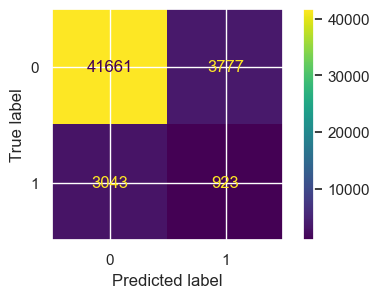

In [66]:
ConfusionMatrixDisplay.from_estimator(model_reg, X_valid, y_valid)

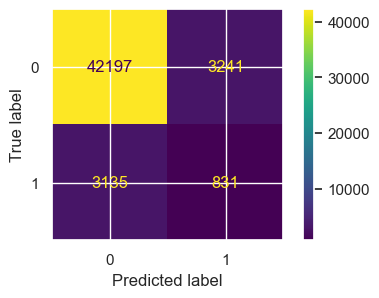

In [67]:
ConfusionMatrixDisplay.from_estimator(model_over, X_valid, y_valid)

We'll go with the model_reg because it has better performance in the recall.

In [68]:
model_reg.named_steps['decisiontreeclassifier'].get_depth()

39

Hyper-parameter tunning: We will  iterate through different values of range of max-depth and create models using these values and fit them on training dataset and store their accuracy scores in the training_acc and validation_acc lists so we can visualiza them later.

In [69]:
depth_ranges = range(1, 38, 2)

In [70]:
#Empty lists for training and validation accuracy scores
training_accuracy = []
validation_accuracy = []

In [71]:
for d in depth_ranges:
    # Create model with max_depth of d
    model = make_pipeline(OrdinalEncoder(),
                     DecisionTreeClassifier(max_depth=d, random_state=40))
    # Fit model to training dataset
    model.fit(X_train, y_train)
    # Calculate training accuracy score and append it to training_accuracy
    training_accuracy.append(model.score(X_train, y_train))
    # Calculate validation accuracy score and append it to training_accuracy
    validation_accuracy.append(model.score(X_valid, y_valid))

print("Training Accuracy Scores:", training_accuracy[:3])
print("Validation Accuracy Scores:", validation_accuracy[:3])

Training Accuracy Scores: [0.919029425903904, 0.919029425903904, 0.9192369000328923]
Validation Accuracy Scores: [0.9197230993441826, 0.9197230993441826, 0.9196623755161525]


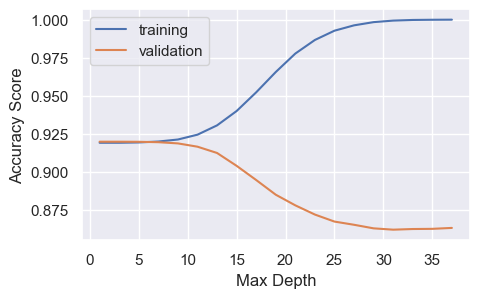

In [72]:
# Plot depth_ranges, training_accuracy and validation_accuracy
plt.plot(depth_ranges, training_accuracy, label='training')
plt.plot(depth_ranges, validation_accuracy, label='validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend();

We'll go with 13 as max_depth

In [73]:
# create pipeline for the model
model = make_pipeline(OrdinalEncoder(),
                     DecisionTreeClassifier(max_depth=13, random_state=40))
# Fit model on X_train and y-train
model.fit(X_train, y_train)

# calculate model score on the training data
accuracy_train = model.score(X_train, y_train)
# calculate model score on the validation data
accuracy_valid = model.score(X_valid, y_valid)

print("Training Accuracy:", round(accuracy_train, 4))
print("Validation Accuracy:", round(accuracy_valid, 4))

Training Accuracy: 0.9305
Validation Accuracy: 0.9123


##### Evaluate

In [74]:
# Test model on testing data
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy:", round(test_accuracy, 4))

Test Accuracy: 0.9115


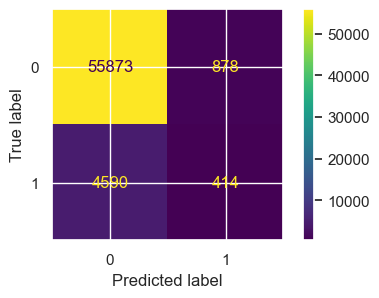

In [75]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

I want to increase recall score, so I decrease threshold for the predicted probabilities

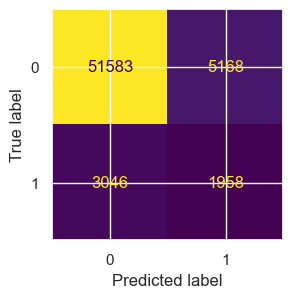

In [76]:
threshold= .2
y_predict_proba = model.predict_proba(X_test)[:, -1]
y_predicted = y_predict_proba > threshold
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted, colorbar=False)

#### Communicate

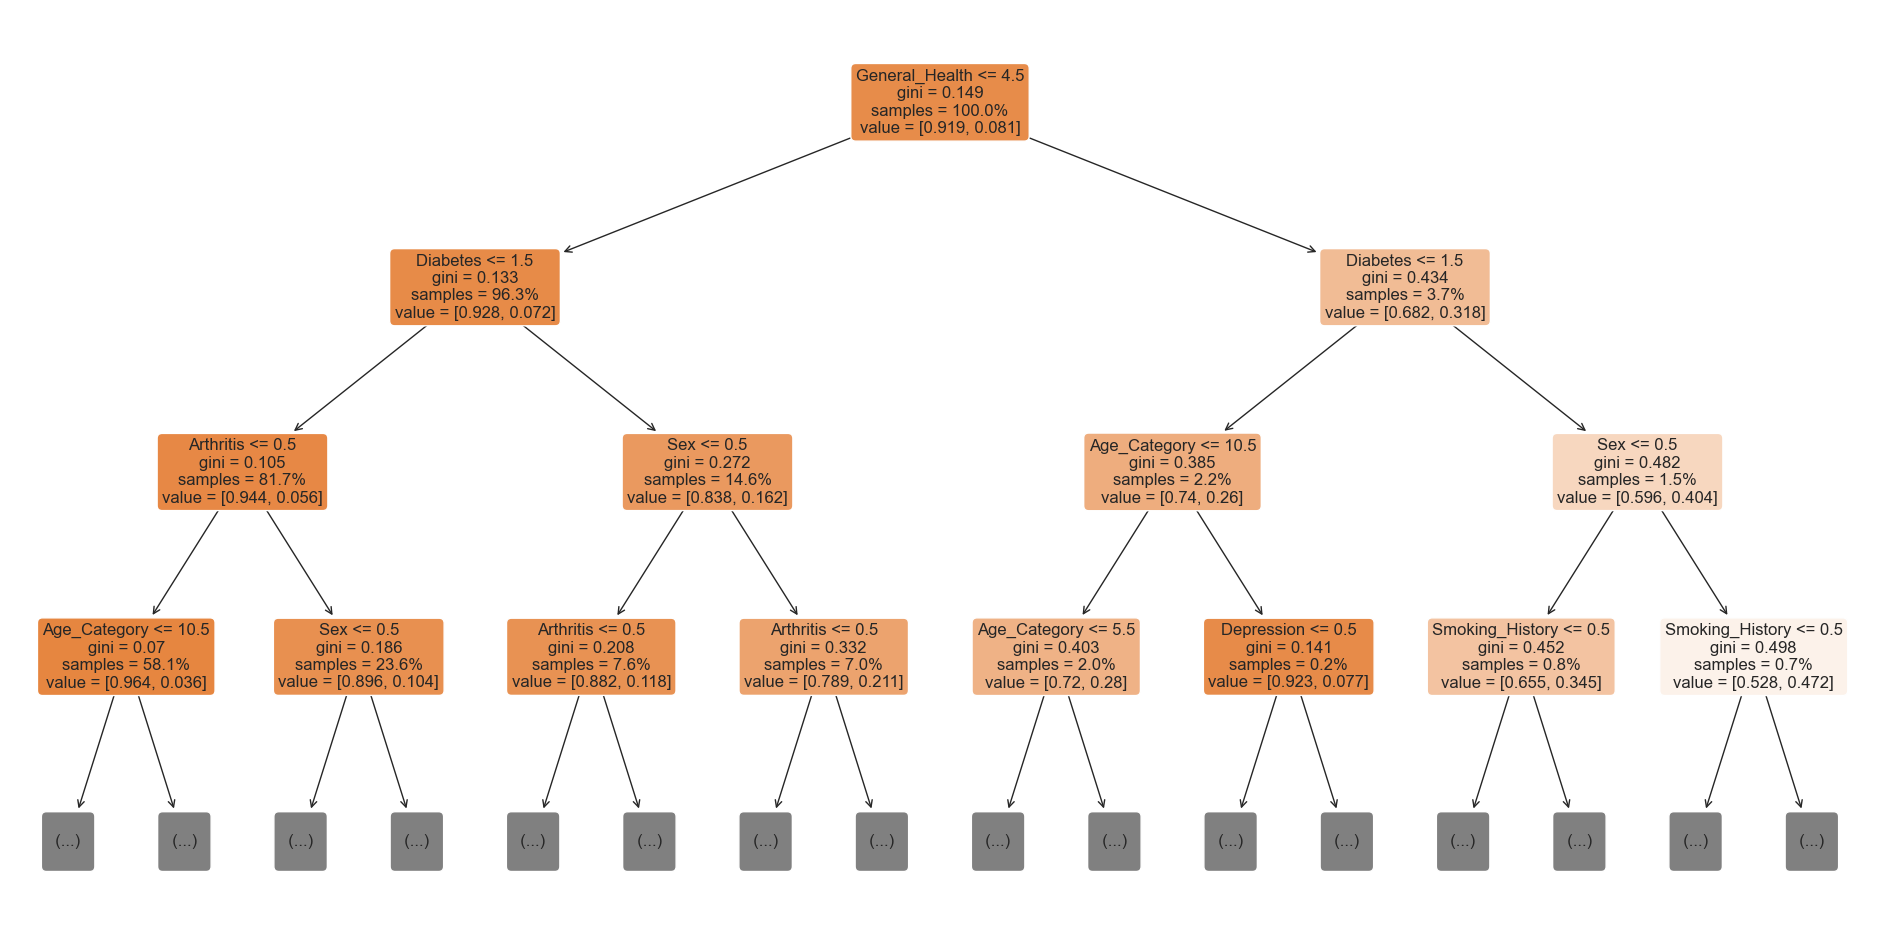

In [77]:
# visualize the decision logic of my model.
fig, ax = plt.subplots(figsize=(24, 12))
# Plot tree
plot_tree(
    decision_tree= model.named_steps['decisiontreeclassifier'],
    feature_names= list(X_train.columns),
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

In [78]:
# Assigning the feature names and importances of my model/ 
features = X_train.columns
importances = model.named_steps['decisiontreeclassifier'].feature_importances_

print("Features:", features[:4])
print("Importances:", importances[:4])

Features: Index(['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer'], dtype='object')
Importances: [0.18734107 0.01378717 0.01263616 0.01523629]


In [79]:
# Create a pandas Series named feat_imp
feat_imp = pd.Series(importances, index = features).sort_values()
feat_imp.head()

Depression      0.011333
Exercise        0.012636
Other_Cancer    0.013014
Checkup         0.013787
Skin_Cancer     0.015236
dtype: float64

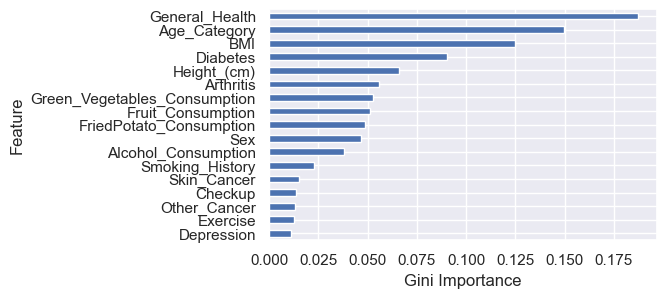

In [80]:
# Horizontal bar chart for Gini Importances
feat_imp.plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature');

Let's make up data and see how it predicts it

In [89]:
# Create function that predicts heart disease
def heart_dis_pred(df, threshold=.2, model=model):
    """It takes in data and predicts heart disease condition using pre-created model
       df: data that we want to use inprediction
       threshold: (Default=0.2) threshold to the predicted probabilities
       model: (default=model) the model used to predict 
       Return: Boolean"""
    
    y_predict_proba = model.predict_proba(df)[:, -1]
    y_predicted = y_predict_proba > threshold
    return y_predicted

In [86]:
make_up_sample = pd.DataFrame([['Poor', 'Never', 0, 0, 0, 1, 1, 0, 0, "30-34", 150.0, 25, 1, 0, 30, 50, 20]], columns = X_train.columns)
make_up_sample

,General_Health,Checkup,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Never,0,0,0,1,1,0,0,30-34,150.0,25,1,0,30,50,20


In [87]:
# Predict if sample has heart disease with threshold=.5 
print(model.predict(make_up_sample))

[1]


In [100]:
# Use heart_dis_pred with threshold of .4
heart_dis_pred(make_up_sample, .4)

array([ True])

In [91]:
makeup_sample2 =  pd.DataFrame([['Fair', 'Within the past 2 years', 1, 0, 0, 0, 1, 1, 1, "55-59", 160.0, 36, 1, 1, 70, 50, 30]], columns = X_train.columns)
makeup_sample2

,General_Health,Checkup,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Fair,Within the past 2 years,1,0,0,0,1,1,1,55-59,160.0,36,1,1,70,50,30


In [92]:
# Predict if sample has heart disease
print(model.predict(makeup_sample2))

[0]


In [99]:
# Use heart_dis_pred with threshold default to .2
heart_dis_pred(makeup_sample2)

array([False])

# Data Analysis Summary

## 1. Data Preparation
- **Loaded Dataset:** `CVD_cleaned.csv`
- **Initial Shape:** 308854 rows, 19 columns
- **Data Cleaning:**
  - Dropped 80 duplicate rows.
  - No missing values or incorrect data types.
  - Final Shape: 308774 rows, 19 columns

## 2. Exploratory Data Analysis (EDA)
- **Summary Statistics:**
  - **Height:** Mean = 170.62 cm, Std = 10.66 cm
  - **Weight:** Mean = 83.59 kg, Std = 21.34 kg
  - **BMI:** Mean = 28.63, Std = 6.52

- **Distribution Insights:**
  - Weight and height have symmetric distributions.
  - BMI is positively skewed.
  - Alcohol consumption, fruit consumption, green vegetables consumption, and fried potato consumption are right-skewed.

- **Age Category Distribution:**
  - Higher frequencies in older age categories (50-75 years).

- **Exercise, Heart Disease, Depression, Diabetes, and Smoking History:**
  - Majority exercise regularly.
  - Most do not have heart disease or diabetes.
  - Depression has higher counts of 'No' but still significant 'Yes'.
  - Smoking history is almost evenly split between 'Yes' and 'No'.

## 3. Key Questions and Findings
### Question 1: Is there a relationship between heart disease and smoking history?

**A) Across Age Categories:**
- Increased heart disease prevalence with smoking, especially in older age groups.
- Visualization showed higher percentages of heart disease in smokers across all age categories.

**B) General Relationship:**
- 12% of smokers have heart disease versus 6% of non-smokers.
- 60% of people with heart disease are smokers, compared to 40% of people without heart disease.

**Conclusion:** There is a significant relationship between smoking and heart disease.

### Question 2: Is the probability of having heart disease the same for smokers and non-smokers?

**Hypothesis Testing:**
- **Null Hypothesis (H0):** The probability of heart disease is the same for smokers and non-smokers (mean difference <= 0).
- **Alternative Hypothesis (H1):** The probability of heart disease is higher for smokers (mean difference > 0).
- **Result:** p-value = 0.0 (reject H0).

**Conclusion:** The probability of having heart disease is higher for smokers than for non-smokers.

### Question 3: Is there a relationship between general health and smoking?

- **Proportion of Smokers Across General Health:**
  - Higher smoking rates are associated with poorer general health.
  - Poor and fair health conditions have smoking rates of 62% and 54%, respectively.

**Conclusion:** There is a negative relationship between general health and smoking.

## 4. Classification: Predicting Heart Disease
- **Model Used:** Decision Tree Classifier
- **Preprocessing:**
  - Dropped `Weight_(kg)` due to multicollinearity with `Height_(cm)`.
  - Transformed binary columns into numerical values.

**Insights:** The model aimed to classify and predict heart disease using various health and lifestyle factors.


<font size="+1"><strong><span style ="color:blue"> Data Limitation </span></strong></font>

The dataset was neat and clean so it did not impose any limitation.

There were no missing values and few duplicates but dropping them wouldn't affect the data much.

I could use better if smoking has different grades such as (heavy, moderate, light) just to demonstrate its affects.

For heart disease prediction, it needs more data(features) for more accurate predictions.